<a href="https://colab.research.google.com/github/Memento2121/Dataflowr_Practicals/blob/main/prac_09_AE_NoisyAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Unsupervised learning with Autoencoder

We first play with MNIST dataset and pieces of code seen during the course.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline

## Loading MNIST

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [3]:
# to be modified if not on colab
root_dir = './data/MNIST/'
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=True, download=True, transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.41MB/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.43MB/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



## Helper Functions

In [4]:
def to_img(x):
    x = x.cpu().data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    The middle row is the encoded vector.
    The encoder is called by model.encoder
    The decoder is called by model.decoder
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [6]:
input_dim = 784
encoding_dim = 64

model = AutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

Why did we take 784 as input dimension?

To find the learning rate, see the documentation for [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [7]:
def train_model(model,loss_fn,data_loader=None,epochs=1,optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view([-1, 784]).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))

In [8]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.121581
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.049449
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.034181
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.030954
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026831
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.023293
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023288
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022254
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020965
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.021735
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.021285
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.021184
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019832
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.019617
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.020182
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.020018
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.020515
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.019070
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.020066
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.019732
Train Epoch: 6 [51200/60000 (85%)]	

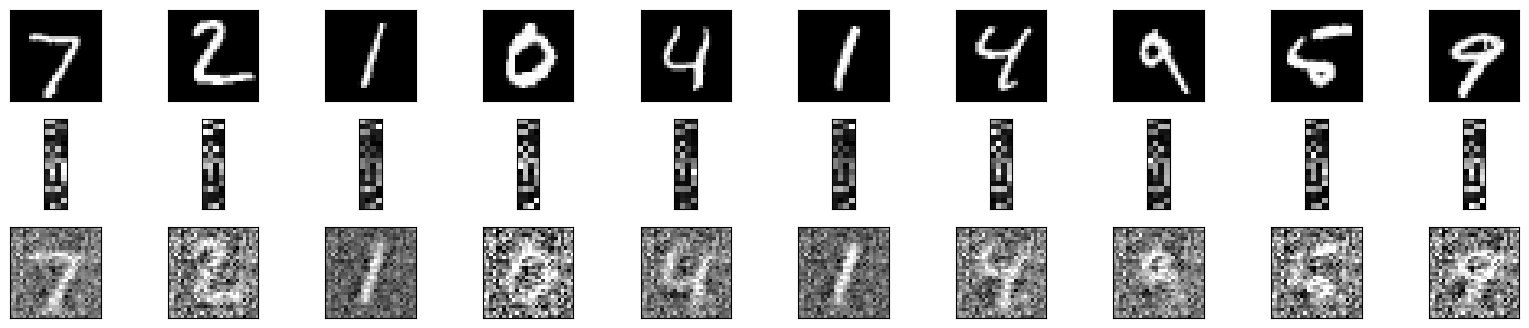

In [9]:
plot_reconstructions(model)

## 1. Exercise: Stacked Autoencoder

Now you will code an autoencoder where both the encoder and the decoder are multilayer perceptron (MLP). You can take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code of dimension 32. For the decoder, you can take the same sequence of dimensions in reverse order.

In [10]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim))
        #

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        #

In [11]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
#loss_fn = torch.nn.MSELoss()
loss_fn = nn.BCEWithLogitsLoss()

In [12]:
train_model(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.694253
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.258703
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.225010
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.209203
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.198009
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.165776
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.171065
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.158911
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.149755
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.147817
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.142009
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.144519
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.139242
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.139261
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.138282
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.132882
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.126775
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.127389
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.123793
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.129736
Train Epoch: 6 [51200/60000 (85%)]	

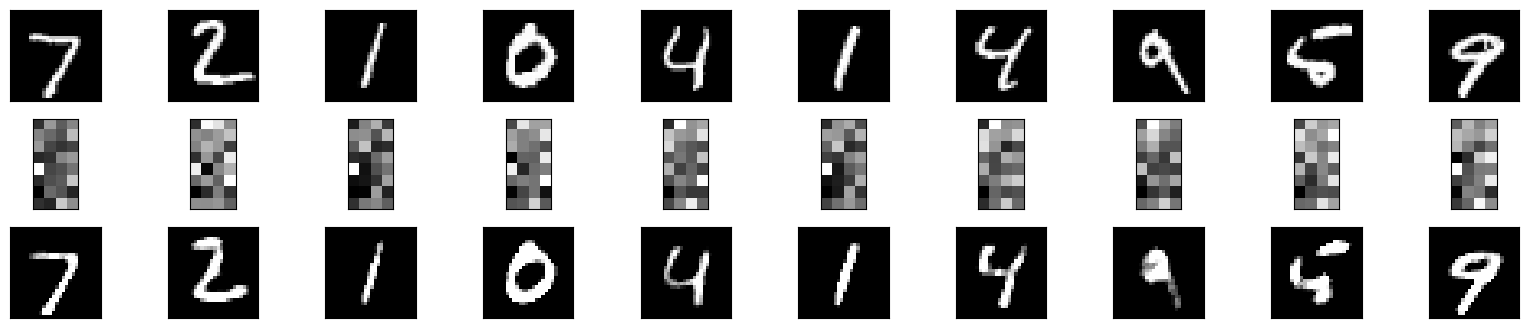

In [13]:
plot_reconstructions(model)

Replace the `MSELoss` with a `BCEWithLogitsLoss` for each pixel. Note the unusual use of `BCEWithLogitsLoss`! You can have a look at the definition of [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy).

## 2. Optional

At this stage, you can code the interpolation described in the lesson to obtain:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/interp_AE.png)

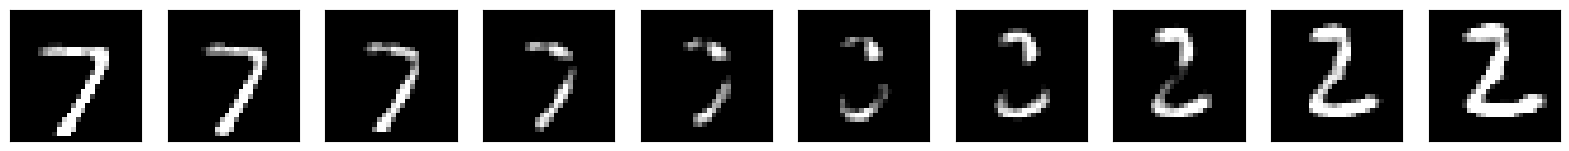

In [14]:
# prompt: interpolation in the latent space

# Assuming the previous code is in the same cell or has been executed.

def interpolate(model, x1, x2, n_steps=10):
    """
    Interpolates between two points in the latent space.
    """
    with torch.no_grad():
        z1 = model.encoder(x1)
        z2 = model.encoder(x2)

        interpolated_zs = []
        for alpha in np.linspace(0, 1, n_steps):
            z = (1 - alpha) * z1 + alpha * z2
            interpolated_zs.append(z)

        interpolated_images = [to_img(model.decoder(z))[0] for z in interpolated_zs]

        return interpolated_images

# Example usage (assuming you have two images x1 and x2 as tensors)
data, _ = next(iter(test_loader))
data = data.view([-1, 784]).to(device)
x1 = data[0].unsqueeze(0) # First image from the test loader
x2 = data[1].unsqueeze(0) # Second image from the test loader


interpolated_imgs = interpolate(model, x1, x2)

# Plot the interpolated images
n = len(interpolated_imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(interpolated_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 3. Exercise: Implement a denoising AE:


Use previous code and with minimal modifications, transform your AE in a denoising AE. Now, you first apply some noise to your input and try to recover the original data at the output. For the noise, you can add some random noise or erase some of the pixels. In this last case, you should obtain something like:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module9/denoising_AE.png)

The first line corresponds to the original digit, the second line to the noisy version of the digit given as input to your network, the third line is the associated code and the last line is the denoised digit obtained by your decoder from the code.

In [18]:
# You need first to modify the training process by adding noise to your data
# Hint if you want to erase pixels: https://stackoverflow.com/questions/49216615/is-there-an-efficient-way-to-create-a-random-bit-mask-in-pytorch
def train_denoiser(model,loss_fn,data_loader=None,epochs=1,optimizer=None, noise=0.1):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        noisy_data = torch.randn(data.size()).to(device) # (bs, 728)
        noisy_data = data * (1 - noise) + noisy_data * noise
        #
        optimizer.zero_grad()
        output = model(noisy_data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

In [29]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCEWithLogitsLoss()

In [30]:
train_denoiser(model, loss_fn,data_loader=train_loader,epochs=10,optimizer=optimizer, noise=0.6)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.693089
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.255283
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.247052
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.249477
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.236546
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.236138
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.238003
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.226037
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.218717
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.214216
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.210520
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.209882
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.202121
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.209581
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.206719
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.203161
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.203168
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.194729
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.197238
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.195138
Train Epoch: 6 [51200/60000 (85%)]	

In [23]:
# Now you need to modify the plot function
def plot_denoising(model, noise=0.1):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, , the second row is the noisy digits,
    the third row is the encoded vector and
    the bottom is the decoder reconstruction.
    """
    # encode then decode
    data, _ = next(iter(test_loader))
    #
    # your code here to compute
    # noisy_data
    # encoded_imgs
    # decoded_imgs
    #
    data, _ = next(iter(test_loader))
    data = data.view([-1, 784])
    data.requires_grad = False
    data = data.to(device)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    decoded_imgs = model.decoder(encoded_imgs)
    noisy_imgs = torch.randn(data.size()).to(device)
    noisy_data = data * (1 - noise) + noisy_imgs * noise
    true_imgs = to_img(data)
    noisy_imgs = to_img(noisy_data)
    decoded_imgs = to_img(decoded_imgs)
    encoded_imgs = encoded_imgs.cpu().data.numpy()

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display corrupted original
        ax = plt.subplot(4, n, i + 1 +n)
        plt.imshow(noisy_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display code
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(-1,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, n, i + 1 +  3*n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

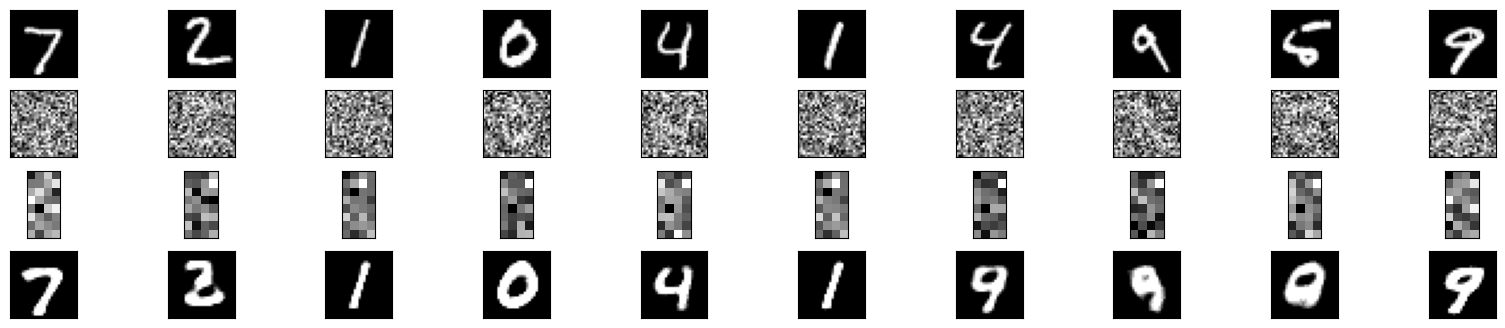

In [31]:
plot_denoising(model, noise=0.6)

In [ ]:
# 4. Optional: how to deal with convolutions?

Hint: start by decreasing the size of your image with `Conv2d` by using a `stride` like:

In [32]:
import torch
import torch.nn as nn

# Define a ConvTranspose2d layer
conv_transpose = nn.ConvTranspose2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1
)

# Input tensor
input_tensor = torch.tensor([[[[1, 2], [3, 4]]]], dtype=torch.float32)

# Apply transposed convolution
output = conv_transpose(input_tensor)

print("Input:\n", input_tensor[0, 0])
print("Kernel:\n", conv_transpose.weight[0, 0])
print("Output:\n", output[0, 0])


Input:
 tensor([[1., 2.],
        [3., 4.]])
Kernel:
 tensor([[-0.2546,  0.2392, -0.2170],
        [-0.2610, -0.0113,  0.0446],
        [-0.2514, -0.1590, -0.1154]], grad_fn=<SelectBackward0>)
Output:
 tensor([[-0.0527, -0.5188, -0.0639],
        [ 0.5173, -2.3290,  0.5976],
        [-0.0752, -0.9516, -0.0865]], grad_fn=<SelectBackward0>)


In [ ]:
conv = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2)
x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

Now use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (or [deconvolution](https://distill.pub/2016/deconv-checkerboard/)) with the same parameters:

In [ ]:
convt = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, stride=2)

In [ ]:
convt(y).shape

To get the same size as `x`, play with `output_padding`.

Now, you have all the tools to build a convolutional autoencoder!

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)